In [9]:
import scanpy as sc
import scarches as sca
import pandas as pd
import numpy as np
from scarches.dataset.trvae.data_handling import remove_sparsity
import pickle

In [2]:
path_data='/storage/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/qtr/'
path_save=path_data+'integrated/gsCellType_query/'
path_gmt='/storage/groups/ml01/code/karin.hrovatin//qtr_intercode_reproducibility-/metadata/'

## Prepare ref and query

In [3]:
# Load data
adata=sc.read(path_data+'adata_annotated.h5ad')
adata.shape

(137964, 13520)

In [4]:
# Query info
ct_query='immune' # Cell types containing this word are removed from reference (but not query)
study_query='spikein_drug' # remove this study from reference and use as query

In [5]:
# Ref
# Subset to all but query study
adata_r=adata.raw.to_adata()[adata.obs.study!=study_query,:]
adata_r.obs['cell_type']=adata[adata_r.obs_names,:].obs.cell_type
print('Ref shape:',adata_r.shape)
# Ductal cells and ductal dublets not included in ref
adata_r=adata_r[~adata_r.obs.cell_type.str.contains(ct_query),:]
# Remove genes expressed in < 20 cells in ref
adata_r=adata_r[:,(adata_r.X!=0).sum(axis=0)>=20].copy()

# Remove top ambient genes
if False:
    ambient=pd.read_table(path_data+'ambient_genes_scores.tsv',index_col=0)
    ambient=set(ambient[(ambient>0.005).any(axis=1)].index)
    adata_r=adata_r[:,[g for g in adata_r.var_names if g not in ambient]]

# Compute HVG across batches
if False:
    # Normalise data for HVG computation
    adata_r_norm=adata_r.copy()
    sc.pp.normalize_total(adata_r_norm, target_sum=1e6, exclude_highly_expressed=True)
    sc.pp.log1p(adata_r_norm)
    # HVG compute and subset
    adata_r=adata_r[:,sc.pp.highly_variable_genes(
        adata_r_norm, flavor='cell_ranger',n_top_genes=10000,
        batch_key="study_sample",subset=False, inplace=False)['highly_variable']].copy()
    del adata_r_norm

print('Ref filtered shape:',adata_r.shape)

Trying to set attribute `.obs` of view, copying.


Ref shape: (113689, 30672)
Ref filtered shape: (109639, 19801)


In [6]:
# Add gene set anno to ref
# Omit gene sets not having at least 5 genes
sca.add_annotations(adata_r, 
                    [path_gmt+'PanglaoDB_markers_27_Mar_2020_mouseEID.gmt',
                    path_gmt+'c2.cp.reactome.v4.0_mouseEID.gmt'], 
                    min_genes=5, clean=False)
print('N used gene sets:',adata_r.varm['I'].shape[1])

# Subset data to only genes in added gene sets
adata_r=adata_r[:,adata_r.varm['I'].sum(axis=1)>0].copy()
print('N retained genes',adata_r.shape[1])

N used gene sets: 828
N retained genes 6918


In [12]:
# Save terms info
# UNUSED - now used in gs script
if False:
    pickle.dump(np.array(adata_r.uns['terms']),open(
        path_data+'integrated/gsCellType_query/model/terms.pkl',
        'wb'))

In [8]:
# Query data - subset to query study cells and ref genes
adata_q=adata.raw.to_adata()[adata.obs.study==study_query,adata_r.var_names]
adata_q.obs['cell_type']=adata[adata_q.obs_names,:].obs.cell_type
print('Query shape:',adata_q.shape)

Trying to set attribute `.obs` of view, copying.


Query shape: (24275, 6918)


In [8]:
# Query batches
print('Query batches:',adata_q.obs.study_sample.unique().to_list())

Query batches: ['spikein_drug_SRR10751509', 'spikein_drug_SRR10751503', 'spikein_drug_SRR10751510', 'spikein_drug_SRR10751504', 'spikein_drug_SRR10751513', 'spikein_drug_SRR10751514', 'spikein_drug_SRR10751507', 'spikein_drug_SRR10751505', 'spikein_drug_SRR10751516', 'spikein_drug_SRR10751511', 'spikein_drug_SRR10751502', 'spikein_drug_SRR10751508', 'spikein_drug_SRR10751506', 'spikein_drug_SRR10751515', 'spikein_drug_SRR10751512']


## Training

In [9]:
# Use whole datasets or only subset for testing out the scripts
testing=False
def subset_data(adata,proportion=0.05):
    np.random.seed(0)
    random_indices=np.random.permutation(list(range(adata.shape[0]))
                                        )[:int(adata.shape[0]*proportion)]
    return adata[random_indices,:].copy()
if testing:
    adata_r_sub=subset_data(adata_r)
    adata_q_sub=subset_data(adata_q)
    adata_sub=subset_data(adata)
else:
    adata_r_sub=adata_r.copy()
    adata_q_sub=adata_q.copy()
    adata_sub=adata.copy()
adata_sub=adata_sub.raw.to_adata()[:,adata_r_sub.var_names]
print('Ref:',adata_r_sub.shape,'Query:',adata_q_sub.shape,'All:',adata_sub.shape)
# Ref: (109639, 6918) Query: (24275, 6918) All: (137964, 6918)

Ref: (109639, 6918) Query: (24275, 6918) All: (137964, 6918)


In [12]:
# Save data for other integration methods
# Subset only to query and ref, not all cells
# UNUSED - now used in gs script
if False:
    adata_integration=adata_sub[adata_r_sub.obs_names.to_list()+\
                                adata_q_sub.obs_names.to_list(),:].copy()
    # Query-ref info
    adata_integration.obs.loc[adata_r_sub.obs_names,'ref_query']='ref'
    adata_integration.obs.loc[adata_q_sub.obs_names,'ref_query']='query'
    # Save
    print('Integration data shape:',adata_integration.shape)
    adata_integration.write(path_data+'integrated/gsCellType_query/model/adata_integration_RefQueryTraining.h5ad')
    del adata_integration
    # Integration data shape: (133914, 6918)

Integration data shape: (133914, 6918)


In [3]:
path_data+'integrated/gsCellType_query/model/adata_integration_RefQueryTraining.h5ad'

'/storage/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/qtr/integrated/gsCellType_query/model/adata_integration_RefQueryTraining.h5ad'

### Create TRVAE model and train it on reference dataset

In [253]:
model = sca.models.TRVAE(
    adata=remove_sparsity(adata_r_sub),
    condition_key='study_sample',
    hidden_layer_sizes=[2048,2048,2048],
    use_mmd=False,
    recon_loss='nb',
    #beta=0.1,
    mask=adata_r.varm['I'].T,
    use_decoder_relu=False,
    mmd_instead_kl=False
)


INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 4121 2048 22
	Hidden Layer 1 in/out: 2048 2048
	Hidden Layer 2 in/out: 2048 2048
	Mean/Var Layer in/out: 2048 728
Decoder Architecture:
	Masked linear layer in, out and cond:  728 4121 22


In [254]:
early_stopping_kwargs = {
    "early_stopping_metric": "val_loss",
    "threshold": 0,
    "patience": 20,
    "reduce_lr": True,
    "lr_patience": 13,
    "lr_factor": 0.1,
}
model.train(
    n_epochs=400,
    alpha_epoch_anneal=None, 
    alpha=0.1, # Higehr more integration
    alpha_kl=15, # Higehr more integration
    early_stopping_kwargs=early_stopping_kwargs,
    use_early_stopping=True, 
    seed=0
)

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


Number of deactivated terms: 0
 |--------------------| 0.2%  - epoch_loss: 7737.95 - epoch_recon_loss: 7632.30 - epoch_kl_loss:    7.04 - val_loss: 6851.63 - val_recon_loss: 6712.88 - val_kl_loss:    9.25
Number of deactivated terms: 0
 |--------------------| 0.5%  - epoch_loss: 7032.88 - epoch_recon_loss: 6841.41 - epoch_kl_loss:   12.76 - val_loss: 6502.02 - val_recon_loss: 6346.61 - val_kl_loss:   10.36
Number of deactivated terms: 0
 |--------------------| 0.8%  - epoch_loss: 6774.74 - epoch_recon_loss: 6580.19 - epoch_kl_loss:   12.97 - val_loss: 6344.76 - val_recon_loss: 6168.91 - val_kl_loss:   11.72
Number of deactivated terms: 0
 |--------------------| 1.0%  - epoch_loss: 6631.62 - epoch_recon_loss: 6441.67 - epoch_kl_loss:   12.66 - val_loss: 6234.46 - val_recon_loss: 6048.00 - val_kl_loss:   12.43
Number of deactivated terms: 0
 |--------------------| 1.2%  - epoch_loss: 6493.49 - epoch_recon_loss: 6309.96 - epoch_kl_loss:   12.23 - val_loss: 6153.38 - val_recon_loss: 5981.7

 |███-----------------| 19.8%  - epoch_loss: 6207.93 - epoch_recon_loss: 6057.43 - epoch_kl_loss:   10.03 - val_loss: 5904.46 - val_recon_loss: 5760.99 - val_kl_loss:    9.56
Number of deactivated terms: 0
 |████----------------| 20.0%  - epoch_loss: 6201.17 - epoch_recon_loss: 6050.60 - epoch_kl_loss:   10.04 - val_loss: 5902.29 - val_recon_loss: 5764.99 - val_kl_loss:    9.15
Number of deactivated terms: 0
 |████----------------| 20.2%  - epoch_loss: 6212.31 - epoch_recon_loss: 6061.26 - epoch_kl_loss:   10.07 - val_loss: 5904.16 - val_recon_loss: 5760.86 - val_kl_loss:    9.55
Number of deactivated terms: 0
 |████----------------| 20.5%  - epoch_loss: 6221.09 - epoch_recon_loss: 6069.80 - epoch_kl_loss:   10.09 - val_loss: 5902.93 - val_recon_loss: 5761.09 - val_kl_loss:    9.46
Number of deactivated terms: 0
 |████----------------| 20.8%  - epoch_loss: 6203.62 - epoch_recon_loss: 6052.74 - epoch_kl_loss:   10.06 - val_loss: 5901.81 - val_recon_loss: 5759.32 - val_kl_loss:    9.50
N

In [255]:
# Mark inactivated terms
adata_r_sub.uns['terms_is_active'] = \
    (model.model.decoder.L0.expr_L.weight.data.norm(p=2, dim=0)>0).cpu().numpy()
print('Inactive terms:')
print([term for i, term in enumerate(adata_r_sub.uns['terms']) 
       if not adata_r_sub.uns['terms_is_active'][i]])

Inactive terms:
[]


In [256]:
# Add integrated embedding
adata_r_sub.obsm['X_integrated'] = model.get_latent(mean=True)[:, adata_r_sub.uns['terms_is_active']]

In [257]:
# Compute neighbours and UMAP
sc.pp.neighbors(adata_r_sub, use_rep='X_integrated')
sc.tl.umap(adata_r_sub)

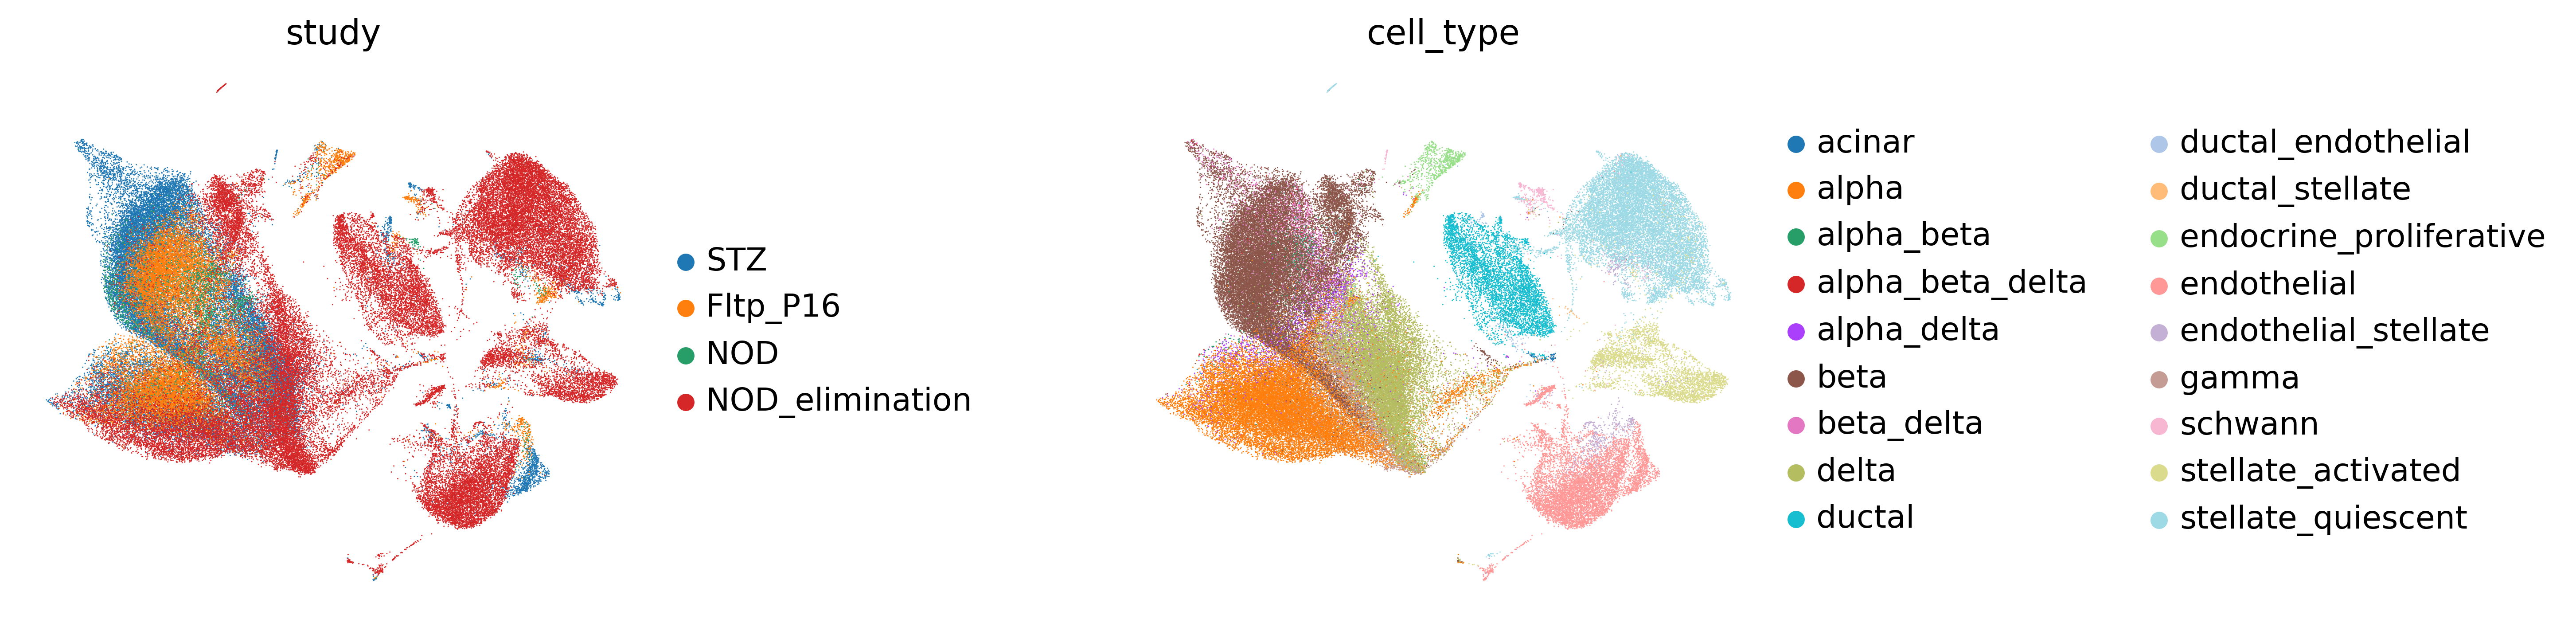

In [258]:
# Plot integrated UMAP
sc.pl.umap(adata_r_sub, color=['study', 'cell_type'], frameon=False, wspace=0.6)

### Add query

In [118]:
# Make query model from original model
model_q = sca.models.TRVAE.load_query_data(remove_sparsity(adata_q_sub), model)


INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 6918 2048 37
	Hidden Layer 1 in/out: 2048 2048
	Hidden Layer 2 in/out: 2048 2048
	Mean/Var Layer in/out: 2048 828
Decoder Architecture:
	Masked linear layer in, out and cond:  828 6918 37


In [119]:
# Train query model
model_q.train(
    n_epochs=400,
    alpha_epoch_anneal=None,  
    alpha_kl=100, 
    early_stopping_kwargs=early_stopping_kwargs,
    use_early_stopping=True, 
    weight_decay=0,
    seed=0
)

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


 |████████████████████| 100.0%  - epoch_loss: 19770.70 - epoch_recon_loss: 19021.43 - epoch_kl_loss:    7.49 - val_loss: 18224.43 - val_recon_loss: 17520.75 - val_kl_loss:    7.04
Saving best state of network...
Best State was in Epoch 399


### Prediction Q&R with Q model
Prediction from query adapated model for all data: Q & R (including the previously ommited cell type).

In [120]:
# Prediction 
adata_sub.obsm['X_integrated'] = model_q.get_latent(
    remove_sparsity( adata_sub.raw.to_adata()[:,adata_r.var_names]).X, 
    adata_sub.obs['study_sample'], mean=True
    )[:, adata_r_sub.uns['terms_is_active']]

In [121]:
# Add term info
adata_sub.uns['terms_is_active']=adata_r_sub.uns['terms_is_active'].copy()
adata_sub.uns['terms']=adata_r_sub.uns['terms'].copy()

In [122]:
# Compute neighbours and UMAP
sc.pp.neighbors(adata_sub, use_rep='X_integrated')
sc.tl.umap(adata_sub)

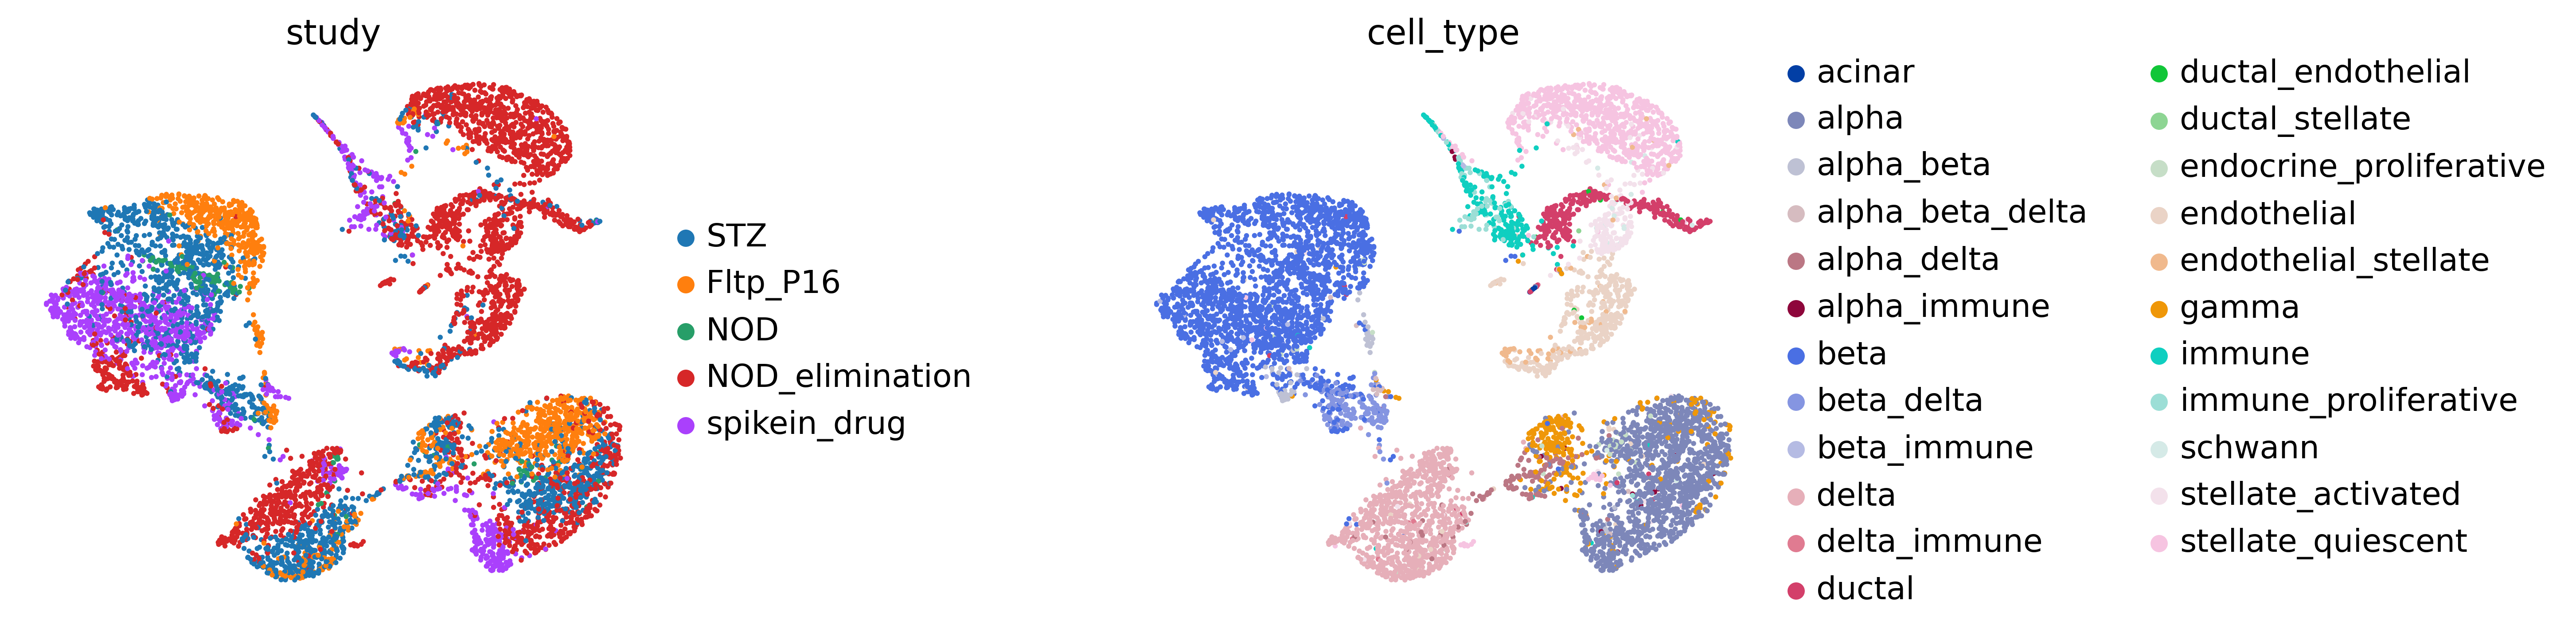

In [123]:
# Plot integrated embedding
sc.pl.umap(adata_sub, color=['study', 'cell_type'], frameon=False, wspace=0.6)

## Save

In [13]:
# Save model
if not testing:
    model.save(path_save)

In [124]:
# Save
if testing:
    adata_sub.write(path_data+'data_integrated_try.h5ad')
else:
    adata_sub.write(path_save+'data_integrated.h5ad')

In [29]:
path_save+'data_integrated.h5ad'

'/storage/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/qtr/data_integrated_try.h5ad'